In [1]:
import os, sys
# To suppress the prints from Iterative Phase Estimation function
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [2]:
import matplotlib.pyplot as plt
def draw_plot(title:str, x:list[float], x_label:str, y:list[float], y_label:str):
    "Return the plot of title with the x-axis and the y-axis labeled as x-label and y-axis relatively."
    plt.plot(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    return plt

Data loaded from ../data\hubbard/h_2.pkl
[1.0020216831261126, 1.4970705400840063]


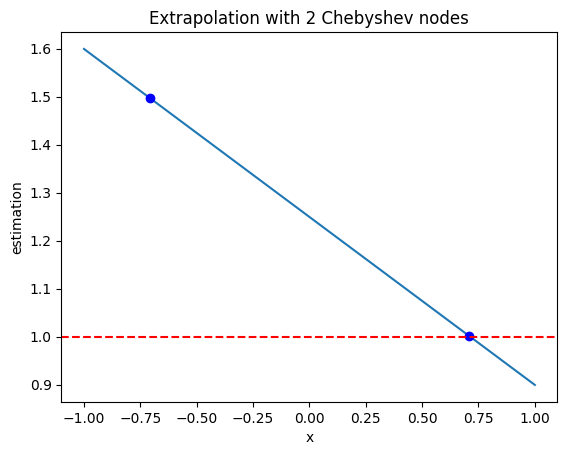

[1.9977562125035724, 1.66082438455979, 1.3348922643275645, 1.5024884677202386]


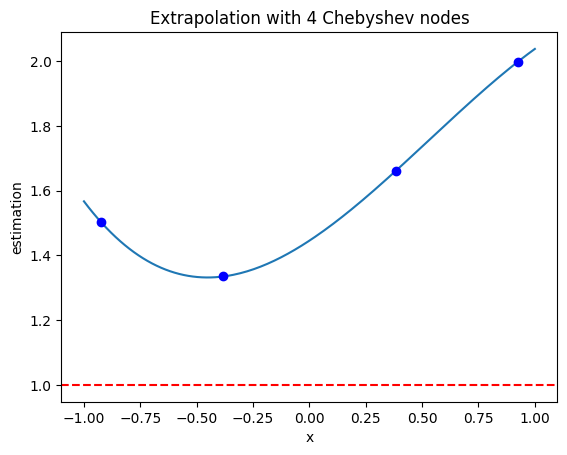

[1.0037986084751438, 1.996102929726618, 1.2487385741898591, 1.4979968923501052, 1.5092523216306826, 1.0203118728579874]


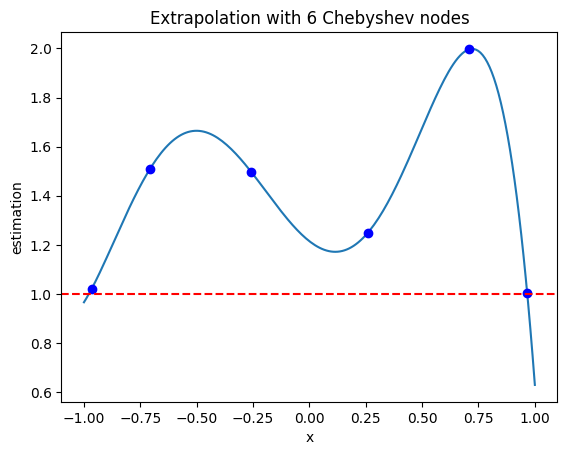

[1.0082563066744417, 1.504538035181192, 1.4898285090285086, 1.3375035286857013, 1.8265307897380947, 1.4998130231262612, 1.9924863500000791, 1.5050761151662615]


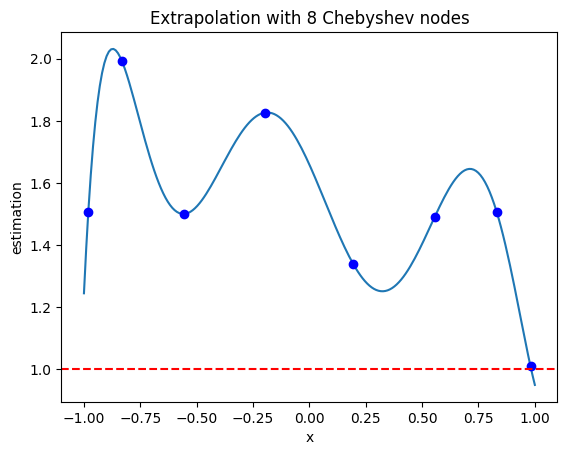

In [20]:
from contextlib import redirect_stdout
from qiskit_aer import Aer
from scripts.algo.iterative_phase_estimation import iterative_phase_estimation_v2
from scripts.algo.chebyshev import chebyshev_nodes, chebyshev_barycentric_interp_point
import scipy
import numpy as np
from qiskit_algorithms import NumPyEigensolver
from scripts.algo.qdrift import qdrift
from scripts.database import DataManager, Hubbard

data = DataManager("../data")  # Create DataManager instance
eigensolver = NumPyEigensolver() # Create Eigensolver
domain = np.linspace(-1, 1, 200) # Domain for extrapolation
selected_backend = Aer.get_backend('qasm_simulator') # Simulation backend from qiskit

ld = data.load('hubbard', "h_2") # load the hubbard model
ld.decompose(-1, 2) # t = +1 and u = +2
decomposition = ld.get_decomp()
obt = decomposition.get_term('obt')
tbt = decomposition.get_term('tbt')
hubbard_matrix = obt.matrix + tbt.matrix
exact_eigenvalue, eigenvectors = scipy.linalg.eig(hubbard_matrix)
expected = min(exact_eigenvalue) # Get the minimum eigenvalue of the hamiltonian

t = 1 # time = 1
num_eval = 10000 # number of iterations of phase estimation


for n in range(2, 10, 2):  # number of the Chebyshev nodes
    data_point = [] # Storage for data points to be interpolated
    nodes = chebyshev_nodes(n) # The n Chebyshev nodes
    for node in nodes:
        estimations = [] # Storage for each eigenvalue estimation of individual unitary 
        N = np.ceil(t / np.abs(node)) # number of samplings
        h_list, v_list = qdrift(ld, N)
        for h in h_list:
            exact_eigenvalue, eigenvectors= scipy.linalg.eig(h) # Get eigenvectors and values for each unitary
            eigenstate = eigenvectors[:, np.argmin(exact_eigenvalue)] # pick eigenstate that corresponds to smallest eigenvalue
            U = scipy.linalg.expm(-1j * h * t) # Evolution for phase estimation
            with HiddenPrints(): # Do Iterative Phase Estimation
                p_0, qc = iterative_phase_estimation_v2(U, num_eval, eigenstate, selected_backend, num_qubits=1)
            estimated_eigenvalue = 2 * np.arccos(np.sqrt(p_0)) # Estimate eigenvalue
            estimations.append(estimated_eigenvalue)
        data_point.append(np.average(estimations)) # Average out the estimations
    
    # plot
    plt = draw_plot(f'Extrapolation with {len(nodes)} Chebyshev nodes', domain, 'x', [chebyshev_barycentric_interp_point(x, n, data_point) for x in domain], 'estimation')
    plt.plot(nodes, data_point, 'bo')
    plt.axhline(expected, color='r', linestyle='--')
    plt.show()